## **DIGITAL SIGNAL AND IMAGE MANAGEMENT** - Davide Croatto, Hubert Nowak, Eleonora Zullo


## **Task 3** - Object detection

## Import libraries and data

In [1]:
!PYTHONHASHSEED=0

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import os
from google.colab import drive
import zipfile
from shutil import copyfile
import xml.etree.ElementTree as ET
import cv2
import random as python_random
import os
from PIL import Image
from PIL import Image
import pandas as pd
import os
import os
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)

In [7]:
drive.mount('/content/gdrive')
copyfile('/content/gdrive/MyDrive/Digital Signals/od.zip', 'od.zip')
zipf = zipfile.ZipFile('od.zip')
zipf.extractall()
zipf.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
csv_file = '/content/data/train_solution_bounding_boxes (1).csv'

In [9]:
train_folder = '/content/data/training_images'

Consistency Check Between Image Files and CSV

In [10]:
image_files = [f for f in os.listdir(train_folder) if f.endswith('.jpg') or f.endswith('.png')]

df = pd.read_csv(csv_file)

csv_image_files = df['image'].unique()

missing_images = [image for image in image_files if image not in csv_image_files]
extra_images = [image for image in csv_image_files if image not in image_files]

if not missing_images and not extra_images:
    print("All Training images have corresponding entries in the CSV file.")
else:
    if missing_images:
        print(f"Missing images in csv : {missing_images}")
    if extra_images:
        print(f"Extra images in csv : {extra_images}")

Missing images in csv : ['vid_4_22160.jpg', 'vid_4_4420.jpg', 'vid_4_12640.jpg', 'vid_4_15120.jpg', 'vid_4_26700.jpg', 'vid_4_11460.jpg', 'vid_4_15160.jpg', 'vid_4_3880.jpg', 'vid_4_13940.jpg', 'vid_4_3500.jpg', 'vid_4_14640.jpg', 'vid_4_16440.jpg', 'vid_4_4040.jpg', 'vid_4_22900.jpg', 'vid_4_16520.jpg', 'vid_4_13440.jpg', 'vid_4_18140.jpg', 'vid_4_22180.jpg', 'vid_4_22040.jpg', 'vid_4_10240.jpg', 'vid_4_11200.jpg', 'vid_4_4160.jpg', 'vid_4_19580.jpg', 'vid_4_22140.jpg', 'vid_4_27120.jpg', 'vid_4_12560.jpg', 'vid_4_14880.jpg', 'vid_4_21340.jpg', 'vid_4_23140.jpg', 'vid_4_14220.jpg', 'vid_4_26620.jpg', 'vid_4_21040.jpg', 'vid_4_7120.jpg', 'vid_4_18300.jpg', 'vid_4_9140.jpg', 'vid_4_6900.jpg', 'vid_4_10220.jpg', 'vid_4_4580.jpg', 'vid_4_23100.jpg', 'vid_4_18100.jpg', 'vid_4_25900.jpg', 'vid_4_18720.jpg', 'vid_4_20060.jpg', 'vid_4_18920.jpg', 'vid_4_15200.jpg', 'vid_4_23300.jpg', 'vid_4_5780.jpg', 'vid_4_19400.jpg', 'vid_4_29380.jpg', 'vid_4_12500.jpg', 'vid_4_14080.jpg', 'vid_4_20480.jpg

In [11]:
len(missing_images)

646

Visualization of missing images from CSV

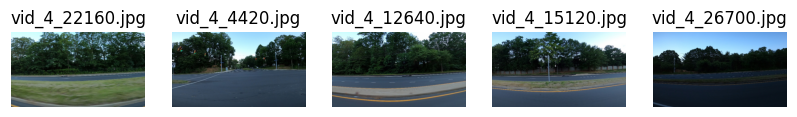

In [12]:
num_samples = min(5,len(missing_images))

plt.figure(figsize=(10,5))

for i in range(num_samples):
    img_path = os.path.join(train_folder,missing_images[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    plt.subplot(1,num_samples,i+1)
    plt.imshow(img)
    plt.title(missing_images[i])
    plt.axis("off")
plt.show()

Updating CSV with missing image entries

In [13]:
updated_csv = 'updated_annotations.csv'
no_car_entries = pd.DataFrame({
    'image':missing_images,
    'xmin': np.nan,
    'ymin': np.nan,
    'xmax': np.nan,
    'ymax': np.nan
})

df = pd.concat([df,no_car_entries],ignore_index=True)

df.to_csv(updated_csv,index=False)

## Data Augmentation - Mirror Image Generation

In [14]:
# Folder containing the images
folder = "/content/data/training_images"

# Supported extensions
extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

# Scan the folder
for filename in os.listdir(folder):
    if filename.lower().endswith(extensions):
        # Full path of the original file
        filepath = os.path.join(folder, filename)

        img = Image.open(filepath)

        # Create the mirrored image
        img_mirror = img.transpose(Image.FLIP_LEFT_RIGHT)

        # New filename with prefix
        new_name = f"reverso_{filename}"
        new_filepath = os.path.join(folder, new_name)

        img_mirror.save(new_filepath)

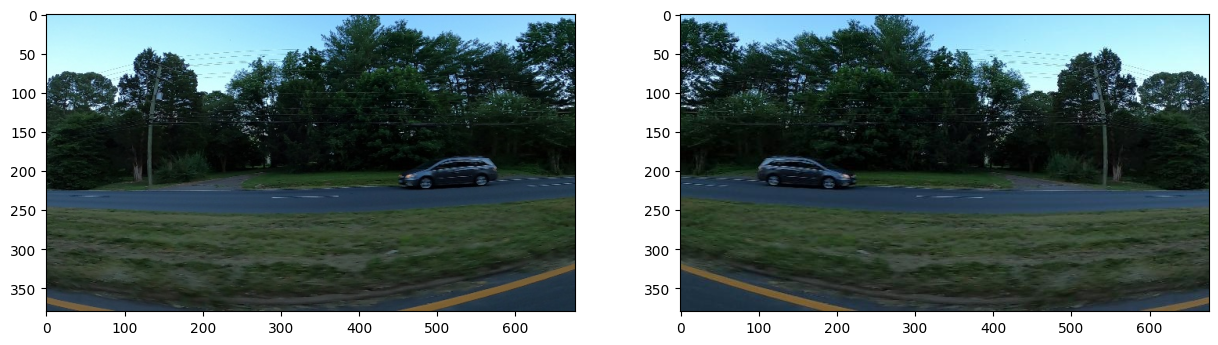

In [15]:
# "Visualizing original and mirrored images"
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(Image.open('/content/data/training_images/vid_4_10100.jpg'))
axes[1].imshow(Image.open('/content/data/training_images/reverso_vid_4_10100.jpg'))

Adjusting annotations for mirrored images

In [16]:
center = 676/2

rev_annotations = df.copy()

rev_annotations['image'] = 'reverso_' + df['image']
rev_annotations['xmax'] = -1 * (df['xmax'] - center) + center
rev_annotations['xmin'] = -1 * (df['xmin'] - center) + center
rev_annotations['ymax'] = df['ymax']
rev_annotations['ymin'] = df['ymin']

In [17]:
rev_annotations.shape

(1205, 5)

In [18]:
rev_annotations.head()

,image,xmin,ymin,xmax,ymax
0,reverso_vid_4_1000.jpg,394.740955,187.035071,348.272069,223.225547
1,reverso_vid_4_10000.jpg,660.836469,187.035071,555.670043,236.430180
2,reverso_vid_4_10040.jpg,436.807525,176.764801,314.031838,236.430180
3,reverso_vid_4_10020.jpg,179.516642,172.363256,45.979740,231.539575
4,reverso_vid_4_10060.jpg,659.369030,186.546010,543.441389,238.386422


In [19]:
rev_annotations.tail()

,image,xmin,ymin,xmax,ymax
1200,reverso_vid_4_10380.jpg,NaN,NaN,NaN,NaN
1201,reverso_vid_4_4020.jpg,NaN,NaN,NaN,NaN
1202,reverso_vid_4_7280.jpg,NaN,NaN,NaN,NaN
1203,reverso_vid_4_16560.jpg,NaN,NaN,NaN,NaN
1204,reverso_vid_4_26780.jpg,NaN,NaN,NaN,NaN


We decided to remove NaN values because they represent images where the object to be detected is not present. By dropping them, we ensure that only images containing the object from the original dataset are retained, while excluding their mirrored versions.  

This adjustment results in a more balanced dataset, with approximately 65% of the images containing the object, compared to the previous 45%. A higher proportion of images with the object improves the model's ability to learn relevant features, reducing the risk of bias towards negative samples and enhancing overall detection performance.

In [20]:
rev_annotations = rev_annotations.dropna()

In [21]:
rev_annotations.shape

(559, 5)

Combining original and mirrored annotations



In [22]:
annotations = pd.concat([df,rev_annotations],ignore_index=True)

In [23]:
annotations.shape

(1764, 5)

In [24]:
annotations.isna().sum()

,0
image,0
xmin,646
ymin,646
xmax,646
ymax,646


## Defining YOLO grid

YOLO-like grid parameters

In [25]:
grid_size = 11
target_size = (682,682,3)

cell_height = target_size[0] / grid_size
cell_width = target_size[1] / grid_size

zero_grid = np.zeros((grid_size, grid_size, 5), dtype=np.float32)

Parsing and converting grid annotations for Object Detection

In [26]:
def parse_grid_annotation(image_path, annotations):
    # Load the image
    im_height = target_size[0]
    im_width = target_size[1]

    # Define padding to transform the image into 682x682
    target_height = 682
    padding_top = (target_height - im_height) // 2
    padding_bottom = target_height - im_height - padding_top

    # Define padding to transform the image into 682x682
    target_width = 682
    padding_left = (target_width - im_width) // 2
    padding_right = target_width - im_width - padding_left

    # Extract the image name from the path
    image_name = os.path.basename(image_path)

    # Find the corresponding row for the image name
    annotation_row = annotations[annotations['image'] == image_name].iloc[0]

    if annotation_row.empty or annotation_row.isna().any().any():
        return np.zeros_like(zero_grid)

    # Extract xmin, ymin, xmax, ymax values from the found row
    xmin = annotation_row['xmin'] + padding_left  # Consider padding
    ymin = annotation_row['ymin'] + padding_top  # Consider padding
    xmax = annotation_row['xmax'] + padding_left  # Consider padding
    ymax = annotation_row['ymax'] + padding_top  # Consider padding

    grid = zero_grid.copy()

    # Convert coordinates to downscaled image
    xmin = xmin / im_width * 682
    xmax = xmax / im_width * 682
    ymin = ymin / target_height * 682  # Adjust scaling to the modified image
    ymax = ymax / target_height * 682

    # Convert VOC format to width/height format
    bbox_width = xmax - xmin + 1
    bbox_height = ymax - ymin + 1

    # Determine the center of the bounding box
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2

    # Determine the cell coordinates the center of the bounding box falls into
    x_cell = int(x_center / cell_width)
    y_cell = int(y_center / cell_height)

    # Determine the offset from the cell center
    x_offset = (x_center % cell_width)
    y_offset = (y_center % cell_height)

    if 0 <= x_cell < grid_size and 0 <= y_cell < grid_size:
        grid[y_cell, x_cell, 0:4] = [
            x_offset / cell_width,
            y_offset / cell_height,
            bbox_width / 682,
            bbox_height / 682  # Adjust for the square image
        ] # Coordinates
        grid[y_cell, x_cell, 4] = 1  # Object presence

    return grid

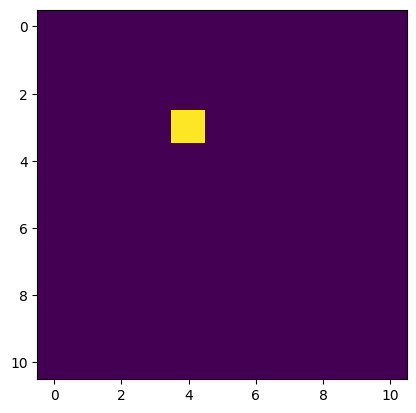

In [27]:
grid = parse_grid_annotation('/content/dataset/data/training_images/vid_4_1000.jpg', annotations)
plt.imshow(grid[:,:,4])

Visualizing grid-based Bounding Boxes on images

In [28]:
def visualize_grid_boxes(image, grid, target_size, grid_size, cell_width, cell_height):
    # Display the image
    plt.imshow(image)

    # Get the image dimensions
    height, width, _ = image.shape  # Note that dimensions are inverted in a numpy array (height, width, channels)

    # Find the cell with the highest probability of containing an object
    y_cell, x_cell = np.unravel_index(np.argmax(grid[:, :, 4]), grid[:, :, 4].shape)

    # Calculate the bounding box coordinates from the grid
    x_center = (x_cell + grid[y_cell, x_cell, 0]) * cell_width
    bbox_width = grid[y_cell, x_cell, 2] * 682  # Adjust to the new size
    xmin = x_center - (bbox_width / 2)

    y_center = (y_cell + grid[y_cell, x_cell, 1]) * cell_height
    bbox_height = grid[y_cell, x_cell, 3] * 682  # Adjust to the new size
    ymin = y_center - (bbox_height / 2)

    # Draw the rectangle (bounding box) on the image
    rect = Rectangle(
        (xmin, ymin),
        bbox_width,
        bbox_height,
        edgecolor="red",
        linewidth=2,
        fill=False,
    )
    plt.gca().add_patch(rect)
    plt.show()

In [29]:
image = keras.utils.load_img('/content/data/training_images/vid_4_1000.jpg')
image = keras.utils.img_to_array(image)

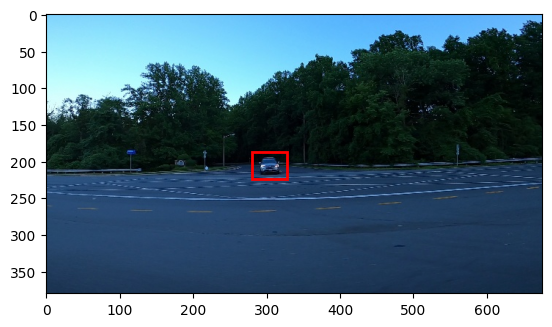

In [30]:
visualize_grid_boxes(image/255, grid, target_size, grid_size, cell_width, cell_height)

## Splitting images into training and validation sets

In [31]:
# Specify the folder containing the images
image_folder = "/content/data/training_images"  # Change to the correct path

# Get the list of files in the folder
image_names = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

# List to save the names of images that have annotations
annotations_list = []

# Loop through all images in the folder
for image_name in image_names:
    # Check if the image has annotations in the dataframe
    if not annotations[annotations['image'] == image_name].empty:
        annotations_list.append(image_name)

# Now annotations_list contains only the names of images with annotations

In [32]:
# Split the data into 25% for test/validation, and 75% for training
val_list = annotations_list[:int(len(annotations_list)/4)]
train_list = annotations_list[int(len(annotations_list)/4):]

In [33]:
print(f'Training images: {len(train_list)}')
print(f'Validation images: {len(val_list)}')

Training images: 1017
Validation images: 339


In [34]:
class DataGenerator(keras.utils.PyDataset):
    def __init__(self, images_list, annotations):
        super().__init__()

        self.images_dir = '/content/data/training_images'
        self.images_list = images_list
        self.annotations = annotations  # DataFrame con le annotazioni

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        # Import image
        image_path = os.path.join(self.images_dir, self.images_list[index])
        image = keras.utils.load_img(image_path, target_size=(380,676))
        image = keras.utils.img_to_array(image)

        # Ottieni la griglia di annotazioni dal dataset
        grid = parse_grid_annotation(image_path, self.annotations)

        return image[None, ...], grid[None, ...]

In [35]:
dgc_train = DataGenerator(train_list, annotations)
dgc_test = DataGenerator(val_list, annotations)

In [36]:
image, grid = dgc_train[0]
print("Image shape:", image.shape)
print("Grid.shape:", grid.shape)

Image shape: (1, 380, 676, 3)
Grid.shape: (1, 11, 11, 5)


## Model definition and training

### Architecture

Building a custom object detection model using MobileNetV2 backbone

In [ ]:
# Initialize backbone from pretrained MobileNetV2
base_net = keras.applications.MobileNetV2(
    include_top=False,  # Exclude the fully connected layers
    weights="imagenet",  # Load pretrained weights from ImageNet
    input_tensor=None,
    input_shape=(682, 682, 3),  # Updated input shape
    pooling=None,
)
base_net.trainable = False  # Freeze the backbone to retain pretrained features

# Define the model architecture
inputs = keras.layers.Input(shape=(380, 676, 3))  # Input shape based on original image dimensions

# Add padding to make the input size 676x676 (only adding padding to top and bottom)
padded_inputs = keras.layers.ZeroPadding2D(padding=((151, 151), (3, 3)))(inputs) # 676 - 380 = 296 → 148 pixels padding at the top, 148 at the bottom

x = keras.applications.mobilenet_v2.preprocess_input(padded_inputs) # Normalize inputs using MobileNetV2's preprocessing function
x = base_net(x) # Pass through the MobileNetV2 backbone

x = keras.layers.Conv2D(256, 1, strides=2, padding='same', activation='relu')(x)
conv_shape = keras.backend.int_shape(x)
x_flattened = keras.layers.Flatten()(x)
x_dense = keras.layers.Dense(2048, activation='relu')(x_flattened)
x_dense = keras.layers.Dense(1024, activation='relu')(x_dense)

# Adjust final dense layer size to match output shape
x_dense = keras.layers.Dense(conv_shape[1] * conv_shape[2] * 5, activation='relu')(x_dense)

x_reshaped = keras.layers.Reshape((conv_shape[1], conv_shape[2], 5))(x_dense) # Reshape the output to match the expected grid format (height, width, 5)

output = keras.layers.Conv2D(5, 1)(x_reshaped) # Apply a final 1x1 convolution to refine the output

# Split output into bounding box coordinates (x, y, w, h) and objectness score
bbox = output[..., :4]  # Extract bounding box values
objectness = keras.layers.Activation('sigmoid')(output[..., 4])  # Apply sigmoid for object presence probability
objectness = keras.layers.Reshape((conv_shape[1], conv_shape[2], 1))(objectness) # Reshape objectness to match bbox dimensions (None, height, width, 1)
final_output = keras.layers.Concatenate()([bbox, objectness])

model = keras.Model(inputs, final_output)
model.summary()

<ipython-input-34-5a0aa4838df9>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_net = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 380, 676, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 682, 682, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide (TrueDivide)  │ (None, 682, 682, 3)    │              0 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract (Subtract)       │ (None, 682, 682, 3)    │              0 │ true_divide[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 22, 22, 1280)   │      2,257,984 │ subtract[0][0]         │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 11, 11, 256)    │        327,936 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 30976)          │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2048)           │     63,440,896 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      2,098,176 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 605)            │        620,125 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 11, 11, 5)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 11, 11, 5)      │             30 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 11, 11)         │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 11, 11)         │              0 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 11, 11, 4)      │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 11, 11, 1)      │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 11, 11, 5)      │              0 │ get_item[0][0],        │
│                           │                        │                │ reshape_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 68,745,147 (262.24 MB)

 Trainable params: 66,487,163 (253.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Loss functions

Object presence loss function using mean squared error (MSE)

In [ ]:
def obj_loss(y_true, y_pred):
    # Get only the object presence element
    obj_true = y_true[..., 4]
    obj_pred = y_pred[..., 4]

    # Object presence regression (MSE)
    obj_loss = tf.reduce_mean(tf.square(obj_true - obj_pred))

    return obj_loss

Bounding box regression loss weighted by object presence

In [ ]:
def bbox_loss(y_true, y_pred):
    # Split the data into bounding boxes and object presence
    bbox_true = y_true[..., :4]
    bbox_pred = y_pred[..., :4]
    obj_true = y_true[..., 4]
    #obj_pred = y_pred[..., 4]

    # Bounding box regression loss (MSE)
    bbox_loss = tf.reduce_mean(tf.square(bbox_true - bbox_pred)*obj_true[...,None])

    return bbox_loss

Weighted sum of object and bounding box losses

In [ ]:
def grid_loss(y_true, y_pred):

    obj_weight = 1.0
    bbox_weight = 100.0

    obj_loss_ = obj_loss(y_true, y_pred)
    bbox_loss_ = bbox_loss(y_true, y_pred)

    return obj_loss_*obj_weight + bbox_loss_*bbox_weight

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


learning_rate = 0.001
optimizers = {
    "RMSprop": keras.optimizers.RMSprop(learning_rate=learning_rate),
    "Adam": keras.optimizers.Adam(learning_rate=learning_rate),
    "SGD": keras.optimizers.SGD(learning_rate=learning_rate)
}

epochs = 100
histories = {}

for opt_name, optimizer in optimizers.items():
    print(f"Training with {opt_name} optimizer...")

    # Define the callbacks list inside the loop
    callbacks_list = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        # Use f-string formatting to create the filename
        ModelCheckpoint(f"best_model_{opt_name}.keras", save_best_only=True) ,
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    ]

    model.compile(loss=grid_loss,
                  optimizer=optimizer,
                  metrics=[obj_loss, bbox_loss])

    history = model.fit(dgc_train,
                        epochs=epochs,
                        verbose=1,
                        validation_data=dgc_test,
                        callbacks=callbacks_list)

    histories[opt_name] = history

Training with RMSprop optimizer...
Epoch 1/100
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - bbox_loss: 0.0046 - loss: 0.4988 - obj_loss: 0.0364 - val_bbox_loss: 2.2796e-04 - val_loss: 0.0280 - val_obj_loss: 0.0052 - learning_rate: 0.0010
Epoch 2/100
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - bbox_loss: 2.4348e-04 - loss: 0.0299 - obj_loss: 0.0055 - val_bbox_loss: 1.6491e-04 - val_loss: 0.0208 - val_obj_loss: 0.0043 - learning_rate: 0.0010
Epoch 3/100
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - bbox_loss: 1.5366e-04 - loss: 0.0197 - obj_loss: 0.0044 - val_bbox_loss: 1.4735e-04 - val_loss: 0.0191 - val_obj_loss: 0.0043 - learning_rate: 0.0010
Epoch 4/100
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - bbox_loss: 1.0838e-04 - loss: 0.0149 - obj_loss: 0.0041 - val_bbox_loss: 1.4158e-04 - val_loss: 0.0185 - val_obj_loss: 0.0043 - learning_rate: 0.0010
Epoch 5/100
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - bbox_loss: 8.7096e-05 - loss: 0.0128 - obj_loss: 0.0041 - val_bbox_loss: 1

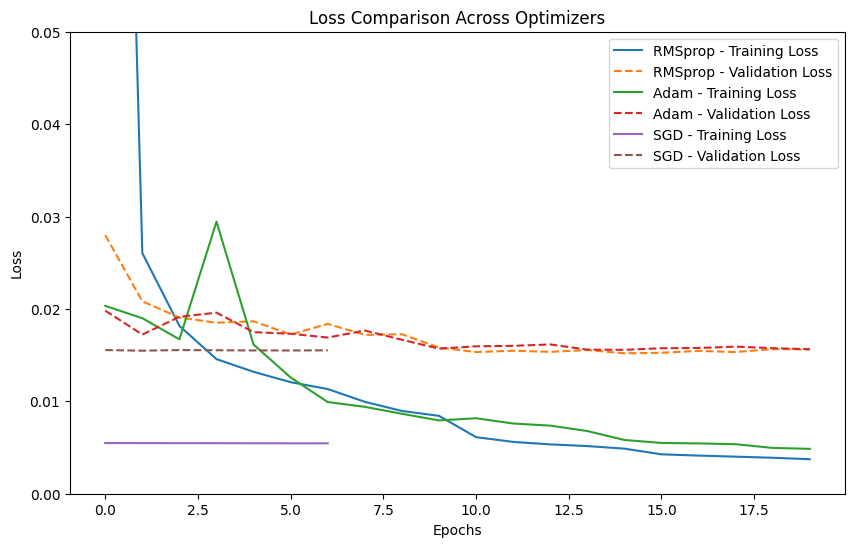

In [ ]:
# Plot loss functions
plt.figure(figsize=(10, 6))
for opt_name, history in histories.items():
    plt.plot(history.history['loss'], label=f"{opt_name} - Training Loss")
    plt.plot(history.history['val_loss'], label=f"{opt_name} - Validation Loss", linestyle='dashed')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.05)
plt.title("Loss Comparison Across Optimizers")
plt.legend()
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/Digital Signals/model_RMSprop.keras')

In [37]:
model_RMSprop = keras.models.load_model("/content/gdrive/MyDrive/Digital Signals/model_RMSprop.keras", compile=False)

We modify some layers of the previous architecture to obtain the following models.

In [ ]:
model1 = keras.models.load_model("/content/gdrive/MyDrive/Digital Signals/objectdetection1.keras", compile=False)

In [ ]:
model1.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33            │ (None, 380, 676, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_16         │ (None, 682, 682, 3)    │              0 │ input_layer_33[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide_11            │ (None, 682, 682, 3)    │              0 │ zero_padding2d_16[0][… │
│ (TrueDivide)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_11 (Subtract)    │ (None, 682, 682, 3)    │              0 │ true_divide_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 22, 22, 1280)   │      2,257,984 │ subtract_11[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 11, 11, 256)    │        327,936 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 30976)          │              0 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 2048)           │     63,440,896 │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 1024)           │      2,098,176 │ dense_38[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 605)            │        620,125 │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 605)            │        366,630 │ dense_40[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 605)            │        366,630 │ dense_41[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 605)            │        366,630 │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 605)            │        366,630 │ dense_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 605)            │        366,630 │ dense_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 605)            │        366,630 │ dense_45[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_14 (Reshape)      │ (None, 11, 11, 5)      │              0 │ dense_46[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)   

 Total params: 70,944,927 (270.63 MB)

 Trainable params: 68,686,943 (262.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model2 = keras.models.load_model("/content/gdrive/MyDrive/Digital Signals/objectdetection2.keras", compile=False)

In [ ]:
model2.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 380, 676, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_11         │ (None, 682, 682, 3)    │              0 │ input_layer_23[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ true_divide_6             │ (None, 682, 682, 3)    │              0 │ zero_padding2d_11[0][… │
│ (TrueDivide)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_6 (Subtract)     │ (None, 682, 682, 3)    │              0 │ true_divide_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 22, 22, 1280)   │      2,257,984 │ subtract_6[0][0]       │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 11, 11, 256)    │        327,936 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 30976)          │              0 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1024)           │     31,720,448 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 605)            │        620,125 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 11, 11, 5)      │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 11, 11, 5)      │             30 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_14 (GetItem)     │ (None, 11, 11)         │              0 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 11, 11)         │              0 │ get_item_14[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_13 (GetItem)     │ (None, 11, 11, 4)      │              0 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 11, 11, 1)      │              0 │ activation_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 11, 11, 5)      │              0 │ get_item_13[0][0],     │
│ (Concatenate)             │                        │                │ reshape_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,926,523 (133.23 MB)

 Trainable params: 32,668,539 (124.62 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## TEST

Comparison between the three models.

In [38]:
def load_img_with_resize_method(image_path, target_size=(380,676), resample=Image.NEAREST):
  image = Image.open(image_path)
  image = image.resize(target_size, resample=resample)
  image = keras.utils.load_img(image_path, target_size=(380,676))
  image = keras.utils.img_to_array(image)
  return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


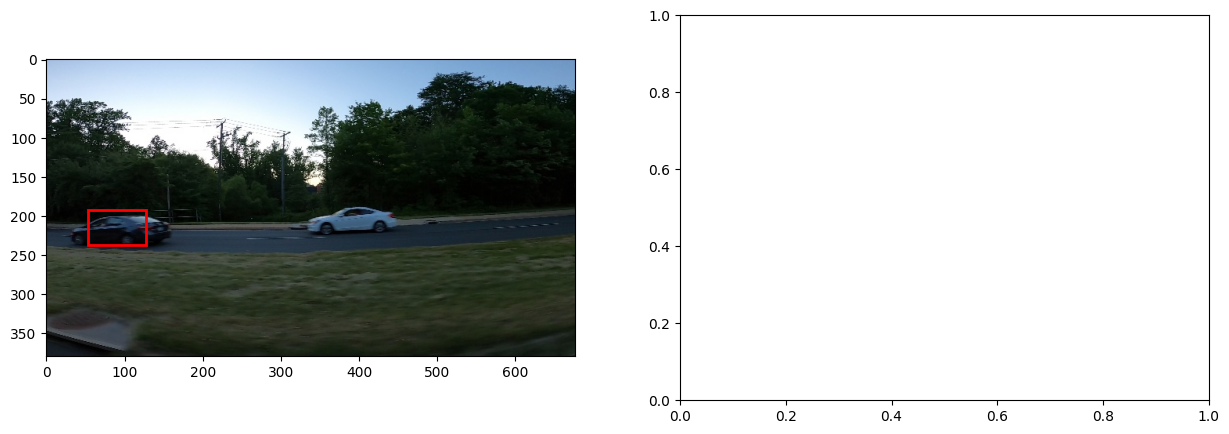

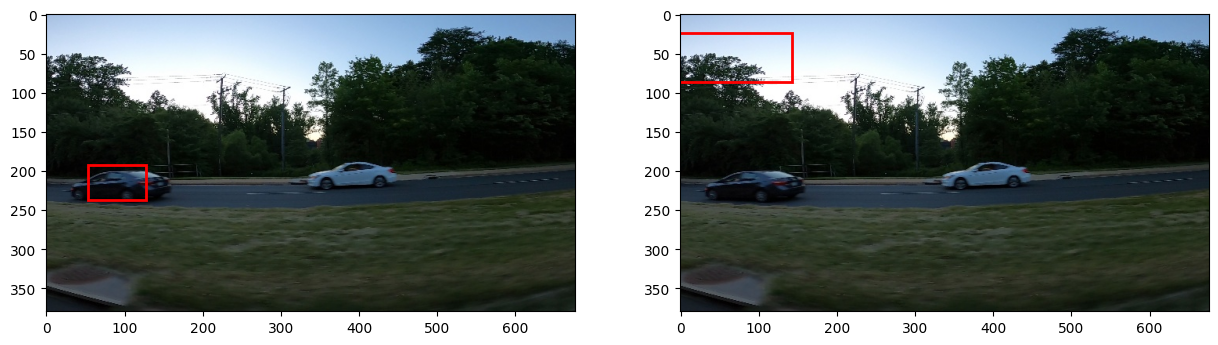

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
dgc_test_check = load_img_with_resize_method('/content/data/testing_images/vid_5_26820.jpg')

# Reshape the image to include the batch size dimension
dgc_test_check = dgc_test_check[np.newaxis, ...]  # Add a new axis at the beginning for the batch size

pred1 = model_RMSprop.predict(dgc_test_check)
pred2 = model1.predict(dgc_test_check)
pred3 = model2.predict(dgc_test_check)

fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # Visualize input and ground truth

plt.sca(axes[0]); visualize_grid_boxes(dgc_test_check[0] / 255.0, pred1[0], target_size, grid_size, cell_width, cell_height)
plt.sca(axes[1]); visualize_grid_boxes(dgc_test_check[0] / 255.0, pred2[0], target_size, grid_size, cell_width, cell_height)
plt.sca(axes[2]); visualize_grid_boxes(dgc_test_check[0] / 255.0, pred3[0], target_size, grid_size, cell_width, cell_height)
plt.tight_layout()

Visualizing training image, ground truth, and model predictions - *from training set*

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


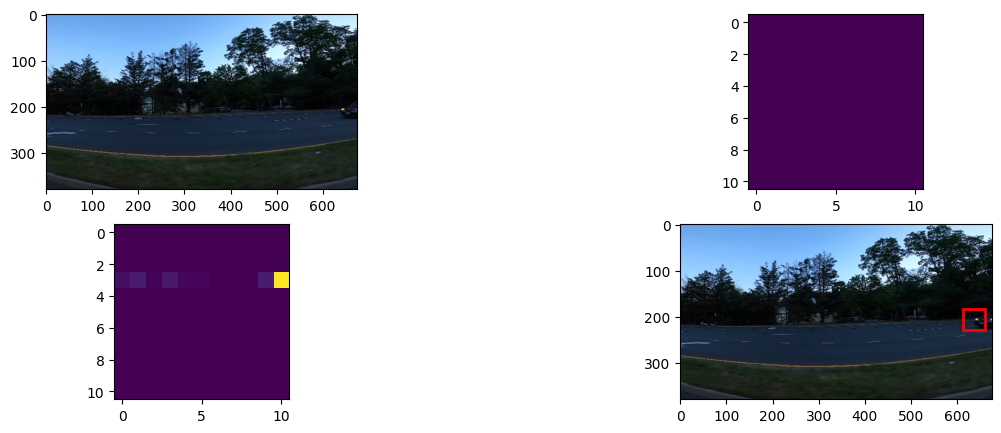

<Figure size 640x480 with 0 Axes>

In [55]:
# Import one specific training image
dgc_train_check = DataGenerator([train_list[120]], annotations)
image = dgc_train_check[0]
# Run model
pred = model_RMSprop.predict(dgc_train_check)
# Visualize input and ground truth
fig, axs = plt.subplots(2, 2, figsize=(15, 5)) # Changed axes to axs
image, grid = dgc_train_check[0]

# Access the correct Axes object using axs[row, column]
axs[0, 0].imshow(image[0]/255.0)  # Changed axes to axs and access the first subplot

# Visualize predictions
axs[0, 1].imshow(grid[0,:, :, 4]) # Changed axes to axs and access the second subplot
axs[1, 0].imshow(pred[0,:,:,4]) # Changed axes to axs and access the third subplot
plt.sca(axs[1, 1]); visualize_grid_boxes(image[0]/255.0, pred[0], target_size, grid_size, cell_width, cell_height) # Changed axes to axs and access the fourth subplot
plt.tight_layout()

Visualizing training image, ground truth, and model predictions - *from validation set*

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


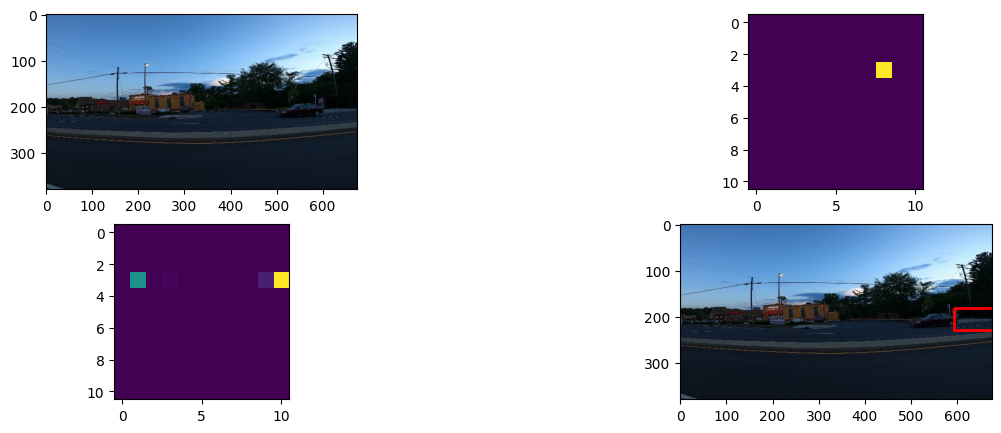

<Figure size 640x480 with 0 Axes>

In [56]:
# Import one specific validation image
dgc_test_check = DataGenerator([val_list[12]], annotations)
image, grid = dgc_test_check[0]
# Run model
pred = model_RMSprop.predict(dgc_test_check)
# Visualize input and ground truth
fig, axs = plt.subplots(2, 2, figsize=(15, 5)) # Changed axes to axs
image, grid = dgc_test_check[0]

# Access the correct Axes object using axs[row, column]
axs[0, 0].imshow(image[0]/255.0)  # Changed axes to axs and access the first subplot

# Visualize predictions
axs[0, 1].imshow(grid[0,:, :, 4]) # Changed axes to axs and access the second subplot
axs[1, 0].imshow(pred[0,:,:,4]) # Changed axes to axs and access the third subplot
plt.sca(axs[1, 1]); visualize_grid_boxes(image[0]/255.0, pred[0], target_size, grid_size, cell_width, cell_height) # Changed axes to axs and access the fourth subplot
plt.tight_layout()

### Out of sample

Loading, resizing, and converting an image to an array with a specified resampling method.

In [41]:
def load_img_with_resize_method(image_path, target_size=(380,676), resample=Image.NEAREST):
  image = Image.open(image_path)
  image = image.resize(target_size, resample=resample)
  image = keras.utils.load_img(image_path, target_size=(380,676))
  image = keras.utils.img_to_array(image)
  return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


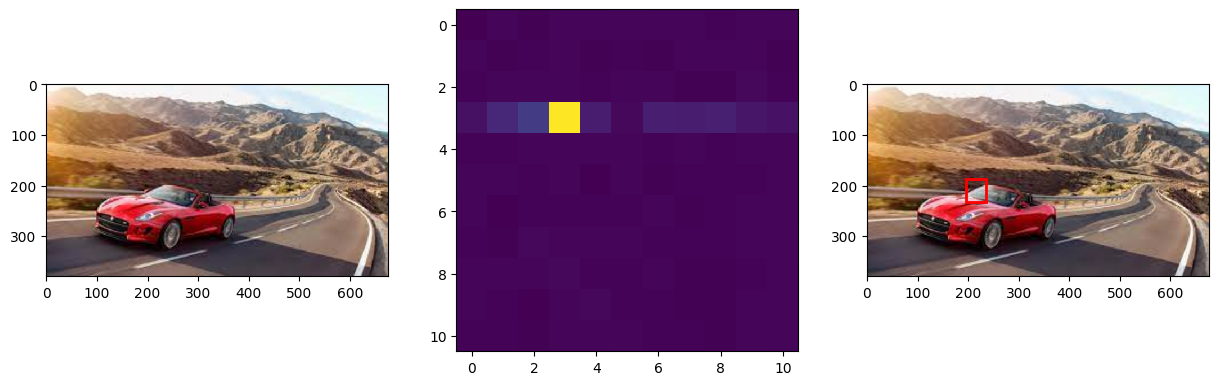

<Figure size 640x480 with 0 Axes>

In [ ]:
dgc_test_check = load_img_with_resize_method('/content/provadsim.jpg')

# Reshape the image to include the batch size dimension
dgc_test_check = dgc_test_check[np.newaxis, ...]  # Add a new axis at the beginning for the batch size

pred = model_RMSprop.predict(dgc_test_check)

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Visualize input and ground truth

axes[0].imshow(dgc_test_check[0] / 255.0)
axes[1].imshow(pred[0,:,:,4])
plt.sca(axes[2]); visualize_grid_boxes(dgc_test_check[0] / 255.0, pred[0], target_size, grid_size, cell_width, cell_height)
plt.tight_layout()